##  Plano de Análise: Macroeconomia vs. E-commerce

In [40]:
import pandas as pd
from bcb import sgs, Expectativas
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# ajusta path
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [42]:
# importa configurações de paleta de cores
import utils.viz_config

### Expectativas de Mercado (Focus)

Fornece as projeções de instituições financeiras para indicadores como **IPCA** e **Selic**. Útil para análise de sentimentos do mercado.

Acesso: Portal de Dados Abertos - **BCB**

### SGS - Sistema Gerenciador de Séries Temporais

Repositório oficial para dados históricos e realizados (**IPCA real**, **Selic efetiva**, etc.). Fundamental para validação estatística.

Acesso: Interface de Consulta **SGS**

In [43]:
def coletar_dados_macro_mensal():
    data_inicio = '2016-01-01'
    data_fim = '2018-12-31'

    # 1. Coleta Selic e IPCA (SGS)
    selic = sgs.get({'selic': 432}, start=data_inicio, end=data_fim)
    ipca_12m = sgs.get({'ipca_12m': 13522}, start=data_inicio, end=data_fim)
    
    # 2. Expectativa Focus
    service = Expectativas()
    exp_12m = service.get_endpoint('ExpectativasMercadoInflacao12Meses')
    df_focus = (
        exp_12m.query()
        .filter(exp_12m.Indicador == 'IPCA', exp_12m.Data >= data_inicio, exp_12m.Data <= data_fim)
        .select(exp_12m.Data, exp_12m.Media)
        .collect()
    )
    
    # Prepara Focus: garante que a data é datetime e define como índice
    df_focus['Data'] = pd.to_datetime(df_focus['Data'])
    ipca_exp = df_focus.groupby('Data')['Media'].mean().to_frame('ipca_exp_12m')

    # 3. Join dos dados diários e preenchimento
    df_macro = selic.join([ipca_exp, ipca_12m]).ffill()
    
    # 4. RESAMPLE: Agrupamento Mensal pela Média
    # 'MS' define o índice como o primeiro dia do mês (Month Start)
    df_mensal = df_macro.resample('MS').mean()
    
    # 5. Cálculo das Taxas Reais (sobre os dados já mensais)
    # Aplicando a Equação de Fisher
    df_mensal['juros_real_ex_ante'] = (((1 + df_mensal['selic']/100) / (1 + df_mensal['ipca_exp_12m']/100)) - 1) * 100
    df_mensal['juros_real_ex_post'] = (((1 + df_mensal['selic']/100) / (1 + df_mensal['ipca_12m']/100)) - 1) * 100
    
    return df_mensal.dropna()

In [44]:
# Executar coleta
df_final = coletar_dados_macro_mensal()

In [45]:
df_final

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post
Date,,,,,
2016-01-01,14.250000,7.054286,10.71,6.721556,3.197543
2016-02-01,14.250000,6.971983,10.36,6.803667,3.524828
2016-03-01,14.250000,6.657903,9.39,7.118176,4.442819
2016-04-01,14.250000,6.327167,9.28,7.451373,4.547950
2016-05-01,14.250000,6.081855,9.32,7.699851,4.509696
2016-06-01,14.250000,5.999917,8.84,7.783104,4.970599
2016-07-01,14.250000,5.757500,8.74,8.030163,5.067133
2016-08-01,14.250000,5.473468,8.97,8.321081,4.845370
2016-09-01,14.250000,5.231167,8.48,8.570496,5.318953


In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2016-01-01 to 2018-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   selic               36 non-null     float64
 1   ipca_exp_12m        36 non-null     float64
 2   ipca_12m            36 non-null     float64
 3   juros_real_ex_ante  36 non-null     float64
 4   juros_real_ex_post  36 non-null     float64
dtypes: float64(5)
memory usage: 1.7 KB


In [47]:
df_final.describe()

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,10.310115,4.721514,5.297500,5.321510,4.761812
std,3.364502,0.960944,2.686049,2.471936,1.855246
min,6.500000,3.669435,2.460000,1.935254,1.855394
25%,6.627016,4.019189,2.860000,2.712875,3.535300
50%,10.169355,4.464405,4.435000,5.562822,4.559967
75%,14.177419,5.069647,8.022500,7.720664,6.570755
max,14.250000,7.054286,10.710000,8.700994,7.712186


In [48]:
# 2. Aplicação do StandardScaler
scaler = StandardScaler()
colunas_para_normalizar = ['selic', 'ipca_exp_12m', 'ipca_12m', 'juros_real_ex_ante', 'juros_real_ex_post'] 

# Criando colunas com sufixo _std
df_final[[c + '_std' for c in colunas_para_normalizar]] = scaler.fit_transform(df_final[colunas_para_normalizar])

In [53]:
df_final.head()

,selic,ipca_exp_12m,ipca_12m,juros_real_ex_ante,juros_real_ex_post,selic_std,ipca_exp_12m_std,ipca_12m_std,juros_real_ex_ante_std,juros_real_ex_post_std
Date,,,,,,,,,,
2016-01-01,14.25,7.054286,10.71,6.721556,3.197543,1.187627,2.462018,2.043625,0.574411,-0.855120
2016-02-01,14.25,6.971983,10.36,6.803667,3.524828,1.187627,2.375155,1.911474,0.608099,-0.676207
2016-03-01,14.25,6.657903,9.39,7.118176,4.442819,1.187627,2.043674,1.545226,0.737136,-0.174380
2016-04-01,14.25,6.327167,9.28,7.451373,4.547950,1.187627,1.694613,1.503693,0.873840,-0.116909
2016-05-01,14.25,6.081855,9.32,7.699851,4.509696,1.187627,1.435710,1.518796,0.975785,-0.137821


In [73]:
df_final.to_csv('dados_macro_olist_v1.csv')
print("Arquivo 'dados_macro_olist_v1.csv' gerado com sucesso!")

Arquivo 'dados_macro_olist_v1.csv' gerado com sucesso!


In [66]:
def plotar_matriz_correlação(df_macro) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_macro.filter(like='_std').corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlação: Variáveis Macro Normalizadas')
    plt.savefig('matriz_correlacao.png')

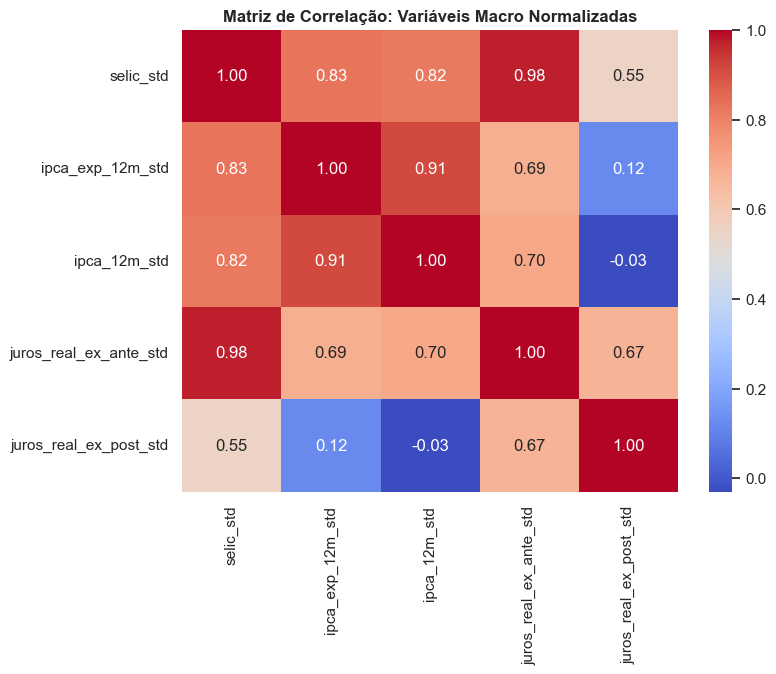

In [67]:
plotar_matriz_correlação(df_final)

In [64]:
def plotar_cenario_macro(df_macro):
        sns.set_theme(style="whitegrid")
        plt.figure(figsize=(14, 7))
        
        # 1. Selic e IPCA Expectativa
        plt.plot(df_macro.index, df_macro['selic'], label='Selic Nominal (%)', color='#1f77b4', linewidth=2.5)
        plt.plot(df_macro.index, df_macro['ipca_exp_12m'], label='Expectativa IPCA (Focus 12m)', color='#ff7f0e', linestyle='--', linewidth=2)

        # 2. Juro Real Ex-Ante (Sólido - O que o mercado esperava)
        plt.plot(df_macro.index, df_macro['juros_real_ex_ante'], 
        label='Juro Real Ex-Ante (%)', color='#d62728', linewidth=2.5)

        # 3. Juro Real Ex-Post (Pontilhado - O que aconteceu de fato)
        plt.plot(df_macro.index, df_macro['juros_real_ex_post'], 
        label='Juro Real Ex-Post (%)', color='#d62728', linestyle=':', linewidth=2, alpha=0.6)
        
        # Títulos e legendas
        plt.title('Cenário Macroeconômico: Decisão (Ex-Ante) vs. Realidade (Ex-Post)', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Data', fontsize=12)
        plt.ylabel('Taxa (%)', fontsize=12)

        # Destaque para a queda da Selic
        plt.annotate('Início do Ciclo de Queda', 
                xy=(pd.Timestamp('2016-10-19'), 14.25), 
                xytext=(pd.Timestamp('2017-03-01'), 14.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)

        # Shaded area baseada no Ex-Ante (decisão do consumidor)
        plt.fill_between(df_macro.index, df_macro['juros_real_ex_ante'], color='#d62728', alpha=0.1)

        plt.legend(loc='upper right', frameon=True, fontsize=10)
        plt.tight_layout()
        plt.savefig('cenario_macro.png')
        plt.show()

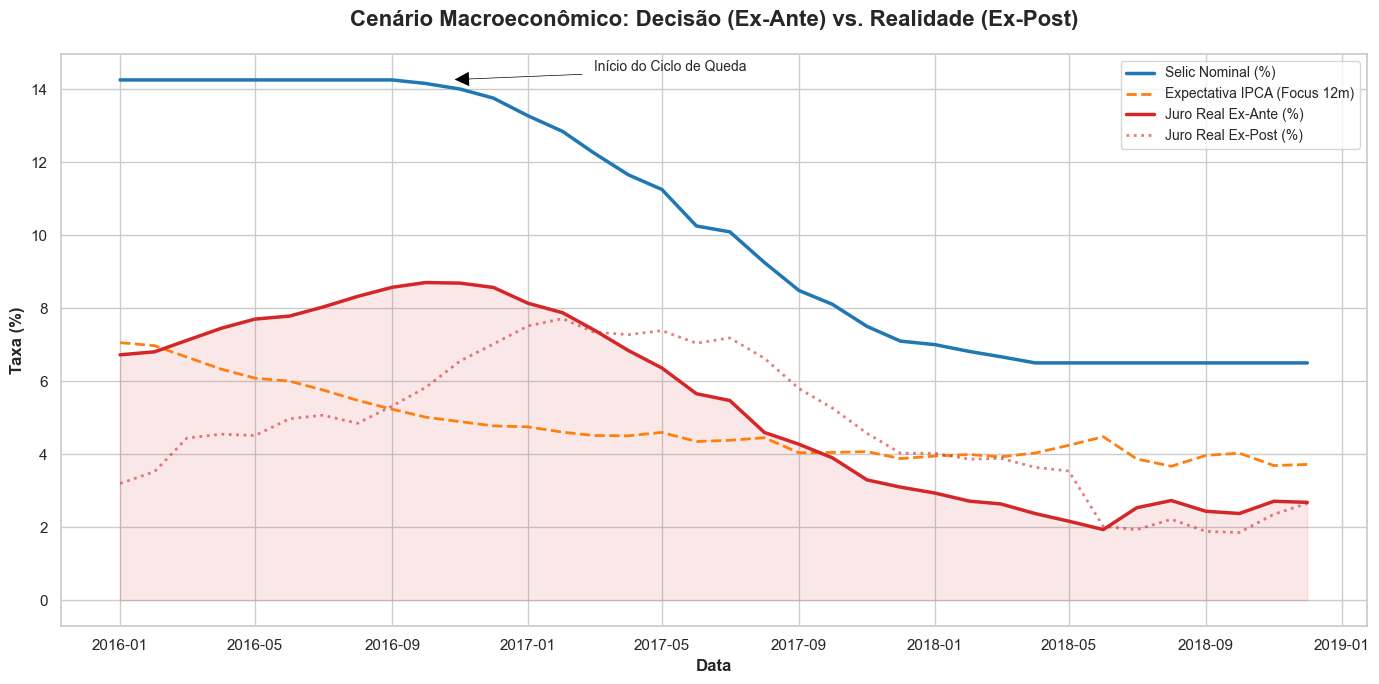

In [65]:
plotar_cenario_macro(df_final)

### Visualização do Cenário de Transição (2016-2018)

O gráfico acima demonstra a **convergência econômica** do período:
1.  **Queda Estrutural:** A Selic Nominal sai de 14,25% e encerra o período em 6,5%.
2.  **Juro Real:** O custo real do dinheiro cai significativamente, o que reduz o custo do crédito para o consumidor final da Olist.
3.  **Impacto no E-commerce:** Esse cenário cria um ambiente propício para o aumento do *Ticket Médio*, especialmente em categorias que dependem de parcelamento (eletrônicos e móveis).

In [62]:
def plotar_dispersao_macro(df_macro):
    plt.figure(figsize=(10, 8))
    
    # Jointplot permite ver a dispersão e a distribuição (histograma) ao mesmo tempo
    g = sns.jointplot(
        data=df_macro, 
        x='ipca_exp_12m', 
        y='selic', 
        kind="reg", # Adiciona a linha de regressão linear
        color="#2c3e50",
        scatter_kws={'alpha':0.4}, # Transparência para ver densidade de pontos
        line_kws={'color':'#e74c3c', 'lw':3} # Linha de tendência em destaque
    )
    
    # Ajustando títulos e eixos
    g.fig.suptitle('Correlação: Expectativa de Inflação vs. Taxa Selic', fontsize=14, fontweight='bold')
    g.fig.subplots_adjust(top=0.92) # Ajusta o título para não cortar
    g.set_axis_labels('Expectativa IPCA (% a.a.)', 'Selic Nominal (% a.a.)', fontsize=12)
    
    plt.savefig('gráfico_de_dispersão.png')
    plt.show()

<Figure size 1000x800 with 0 Axes>

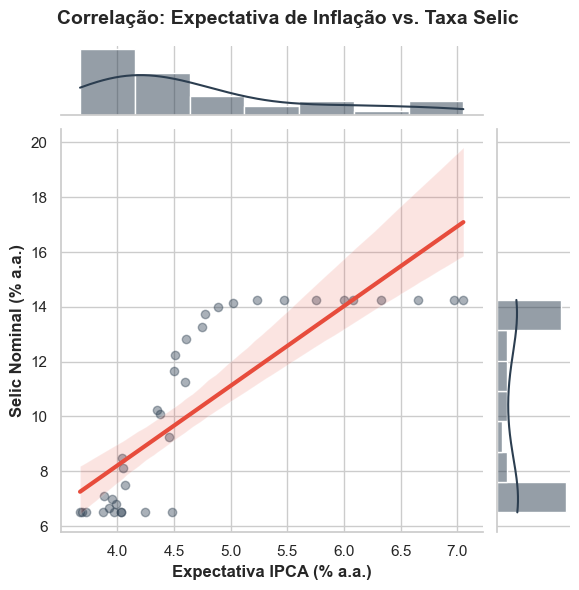

In [63]:
plotar_dispersao_macro(df_final)

In [70]:
def plotar_distribuicao_juro_real(df_macro):
    plt.figure(figsize=(12, 6))
    
    # Criando o histograma com a curva de densidade (KDE)
    sns.histplot(df_macro['juros_real_ex_ante'], kde=True, color='#d62728', bins=20)
    
    # Adicionando linhas de referência (Média e Mediana)
    plt.axvline(df_macro['juros_real_ex_ante'].mean(), color='black', linestyle='--', label=f"Média: {df_macro['juros_real_ex_ante'].mean():.2f}%")
    plt.axvline(df_macro['juros_real_ex_ante'].median(), color='blue', linestyle=':', label=f"Mediana: {df_macro['juros_real_ex_ante'].median():.2f}%")
    
    plt.title('Distribuição da Taxa de Juros Real Ex-Ante (2016-2018)', fontsize=14, fontweight='bold')
    plt.xlabel('Juro Real (% a.a.)', fontsize=12)
    plt.ylabel('Frequência (Dias)', fontsize=12)
    plt.legend()
    
    plt.show()

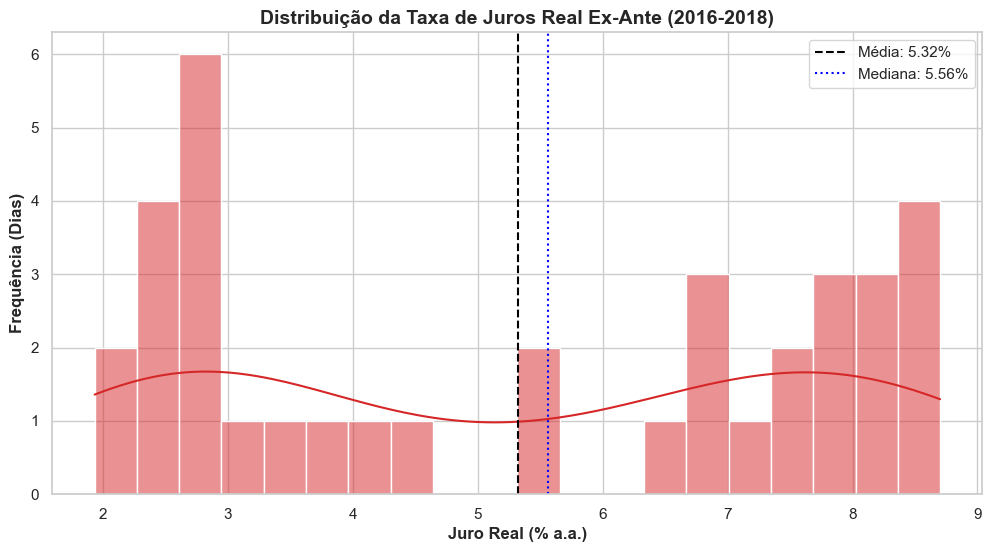

In [71]:
plotar_distribuicao_juro_real(df_final)

##  Síntese da Estrutura Econômica

A análise preliminar das variáveis macro (SGS e Focus) estabelece que:

* **Trajetória:** Houve um choque positivo de oferta de crédito (queda da Selic).
* **Aderência:** A autoridade monetária seguiu as expectativas do mercado (Linha de Regressão).
* **Custo Médio:** O Juro Real médio enfrentado pelo ecossistema Olist foi de `5.32%` (Média da Distribuição).
